# Discontinuous solutions and how ${\tt reyna}$ handles this

To understand this notebook fully, please refer to the advection_reaction notebook first for the full discretisation. This notebook is an applications focused set-up. This demonstrates the flexibilty of ${\tt reyna}$ and how the core library can be built on to generate suitable simulations for many scenarios.

### Problem Set-up

${\tt reyna}$, being a discontinuous Galerkin package, is able to handle solutions with discontinuities in. This often happens in tranport-based set-ups with discontinuous boundary conditions. For this example, we consider the transport equation

$$
\vec{b}\cdot\nabla u = 0, \quad \vec{x}\in\Omega = (0, 1)^2
$$

where $\vec{b} = (2, 1)^T$. To assert a discontinuous soultion, we set hte inflow boundary conditions to be equal to

$$
u(x, y) = \mathbb{I}\{4y - 2x - 1 > 0\}, \quad (x, y)\in\Gamma_-
$$


### Mesh Generation

To demonstrate the code fully, we provide two scenarios; one where elements are alimged to the discontinuity and one where they are not. This will additionally demontrate the flexibilty of the mesh generation algorithm. For both meshes, we use 256 elements.

In [69]:
import numpy as np

from reyna.polymesher.two_dimensional.domains import RectangleDomain
from reyna.polymesher.two_dimensional.main import poly_mesher

domain = RectangleDomain(bounding_box=np.array([[0, 1], [0, 1]]))

n_elements = 256
unaligned_mesh = poly_mesher(domain, max_iterations=10, n_points=n_elements)

To create a mesh that is aligned to the characteristic, we are able to set some fixed points in place. This will generate a split in the mesh. This is shown in the code below. We use the ```fixed_points``` variable of the ```Domain``` object to fix some elements of the mesh. Mirroring points over a line gives a clean divide of the domain.

In [70]:
# Initial points above the line
x = np.linspace(0.02, 0.98, 30)
y = 0.5 * x + 0.26

points = np.column_stack([x, y])

# Reflect the points over the line and stack them
d = (x + (y - 0.25) * 0.5)
demoninator = 1.0 + 0.5 ** 2
x_ref = 2.0 * d / demoninator - x
y_ref = d / demoninator - y + 0.5
reflected_points = np.stack([x_ref, y_ref], axis=1)

points = np.concatenate([points, reflected_points], axis=0)

# Set the number of random points appropriately
n_elements = 256 - points.shape[0]

# Generate the domain and mesh accordingly
domain = RectangleDomain(bounding_box=np.array([[0, 1], [0, 1]]), fixed_points=points)
aligned_mesh = poly_mesher(domain, max_iterations=10, n_points=n_elements)


We now show these meshes side by side to demonstrate this

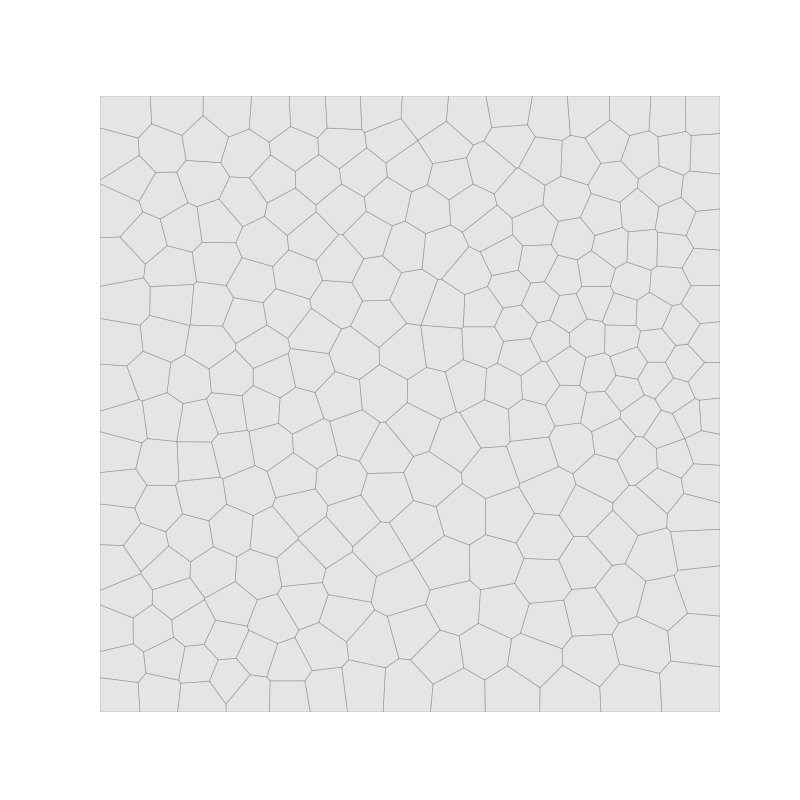

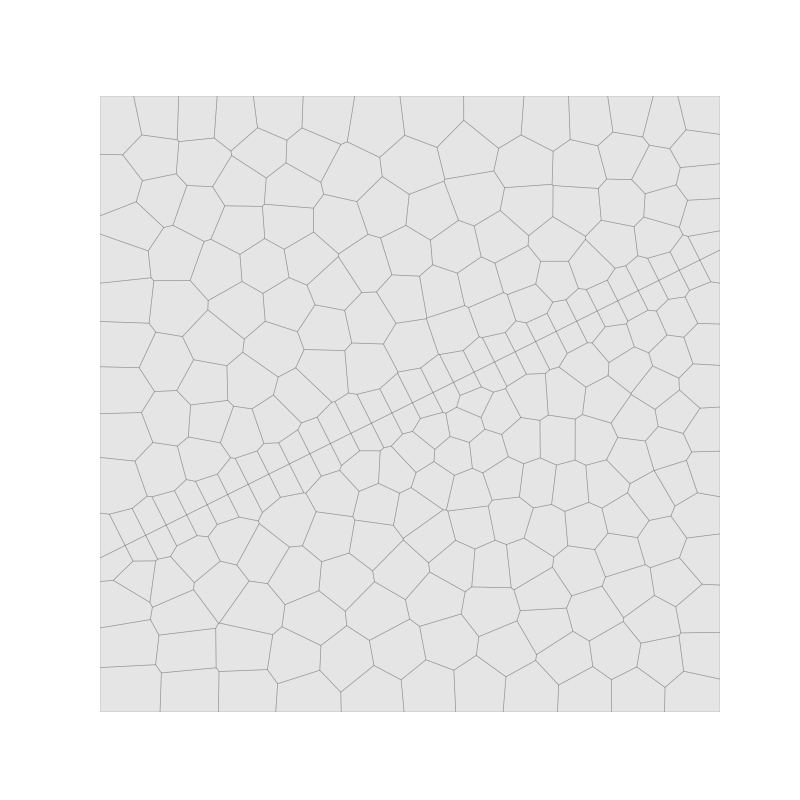

In [71]:
from reyna.polymesher.two_dimensional.visualisation import display_mesh

display_mesh(unaligned_mesh)
display_mesh(aligned_mesh)

We see that there is a split now in the computational mesh. This can be used now to generate solutions.

## Solving the PDE

To begin, we define the functions required.

In [72]:
advection = lambda _x: np.concatenate(
    (2 * np.ones((_x.shape[0], 1), dtype=float),  np.ones((_x.shape[0], 1), dtype=float)), axis=1
)
bcs = lambda _x: (4.0 * _x[:, 1] - 2.0 * _x[:, 0] - 1.0 > 0).astype(np.float64)

We may then apply the DG solver as in the other examples.

In [73]:
from reyna.geometry.two_dimensional.DGFEM import DGFEMGeometry
from reyna.DGFEM.two_dimensional.main import DGFEM

unaligned_geometry = DGFEMGeometry(unaligned_mesh)
unaligned_dg = DGFEM(unaligned_geometry, polynomial_degree=1)

unaligned_dg.add_data(advection=advection, dirichlet_bcs=bcs)
unaligned_dg.dgfem(solve=True)


aligned_geometry = DGFEMGeometry(aligned_mesh)
aligned_dg = DGFEM(aligned_geometry, polynomial_degree=1)

aligned_dg.add_data(advection=advection, dirichlet_bcs=bcs)
aligned_dg.dgfem(solve=True)

From here, we may plot the solutions and see the comparison.

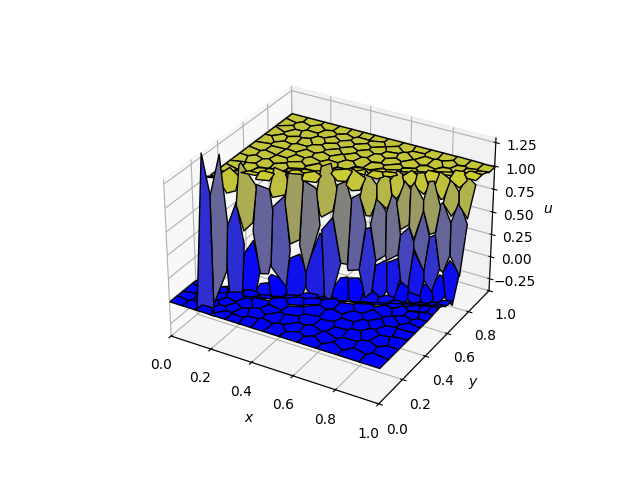

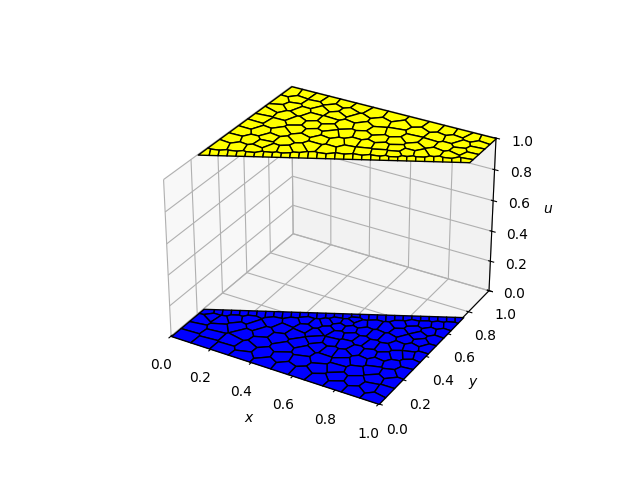

In [74]:
%matplotlib widget

unaligned_dg.plot_DG()
aligned_dg.plot_DG()

We can see that the aligned mesh performs better. Both meshes display the flexibility of the code in question. We are able to use polygonal spatial decompositions to generate more suitable meshes which are able to capture the full discontinuous behaviour of our solution.